In [1]:
##libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt

ModuleNotFoundError: No module named 'statsmodels'

,EOYBYear,collectDate,marshName,siteName,locationID,monitoringPurpose,Transect,Replicate,speciesName,liveMass,deadMass,totalMass,latitude,longitude
0,1999,NaT,Bellvue,Bellvue,4,EOYB,C,b,Distichlis spicata,128.00,121.60,249.60,37.625273,-75.671577
1,1999,NaT,Bellvue,Bellvue,4,EOYB,C,a,Distichlis spicata,60.80,25.60,86.40,37.625273,-75.671577
2,1999,NaT,Bellvue,Bellvue,2,EOYB,A,a,Distichlis spicata,44.80,54.40,99.20,37.625273,-75.671577
3,1999,NaT,Bellvue,Bellvue,2,EOYB,A,b,Distichlis spicata,4.80,1.60,6.40,37.625273,-75.671577
4,1999,NaT,Bellvue,Bellvue,4,EOYB,A,a,Distichlis spicata,38.40,19.20,57.60,37.625273,-75.671577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8232,2017,2017-08-04,Gator Tract,Gator,3,EOYB,C,a,Spartina alterniflora,42.72,0.00,42.72,37.167409,-75.940586
8233,2018,2017-08-14,Box Tree,Box_Tree,1,EOYB,C,a,Combined Dead,0.00,148.80,148.80,37.395746,-75.876094
8234,2018,2017-08-14,Box Tree,Box_Tree,1,EOYB,C,a,Spartina alterniflora,255.04,0.00,255.04,37.395746,-75.876094
8235,2018,2017-08-14,Hog Island North,Hog_N,3,EOYB,C,b,Combined Dead,0.00,199.84,199.84,37.451132,-75.672871


mean biomass is: 241.83347025948103
median biomass is: 101.44


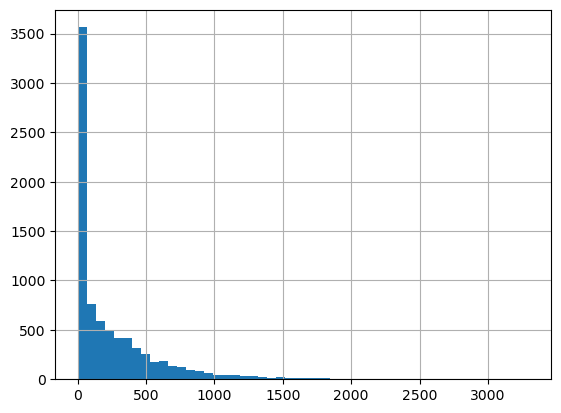

In [6]:
##read data - biomass, Virginia LTER
##Mac:
# df = pd.read_csv('/Users/asariversjulien/Documents/Data/CSV files/Virginia_ChristianBlum.csv', skiprows=21)
# df_wq = pd.read_csv('/Users/asariversjulien/Documents/Data/CSV files/Virginia_WQ.csv', skiprows=21)

##PC:
df = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Virginia_ChristianBlum.csv', skiprows=21)
# df_wq = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Virginia_WQ.csv', skiprows=21, \
#                     encoding='cp1252') ##Have no idea what's with this encoding argument but it works

##Begin:
# df = df[df['speciesName'] == 'Spartina alterniflora'] ##only low marsh and creekbank?

df = df[
    [
        'EOYBYear', 'collectDate', 'marshName', 'siteName', 'locationID', 'monitoringPurpose','Transect', 'Replicate',
        'speciesName', 'liveMass', 'deadMass', 'totalMass', 'latitude', 'longitude'
    ]
]

df['collectDate'] = pd.to_datetime(df['collectDate'])

df['liveMass'] = 16 * df['liveMass'] ##look at histograms
df['deadMass'] = 16 * df['deadMass']
df['totalMass'] = 16 * df['totalMass']

locations = [1, 2] ## 1 = creekbank; 2 = low marsh
#df = df[df['locationID'].isin(locations)] ##MOSTLY Spartina alterniflora-only plots; in other zones plots were mixed

# df_wq['measureDate'] = pd.to_datetime(df_wq['measureDate'])

max(df['liveMass'])

#df['liveMass'].hist(by=df['siteName'])
df['liveMass'].hist(bins = 50)

df.loc[df.marshName == 'Hog Island North', 'siteName'] = "Hog_N"
df.loc[df.marshName == 'Hog Island South', 'siteName'] = "Hog_S" ##Important for importing lat/longs

##IMPORTANT NOTE: 2017 data does not distinguish live from dead biomass due to a freezer failure

display(df)

print('mean biomass is: ' +str(df['liveMass'].mean()))
print('median biomass is: ' +str(df['liveMass'].median()))

In [7]:
##summary statistics
df_means = df.groupby(['EOYBYear', 'siteName'], as_index = False).aggregate({'liveMass':[np.mean, np.size, np.std], \
    'longitude':[np.mean, np.std], 'latitude':[np.mean], 'EOYBYear':'first', 'speciesName':'first'})

df_means.columns = ['siteName','liveMass','n','std', 'Longitude', 'lon_std', 'Latitude', 'Year', 'Species']

df_means = df_means[df_means['siteName'] != 'Broad_Creek'] ##Remove from dataset

# df_sem = df.groupby('EOYBYear').sem()

display(df_means)
#df_sem

##export data
out_dir = os.path.expanduser('~/Downloads')
out_csv = os.path.join(out_dir, 'va_meanmass.csv')

# df_means.to_csv(out_csv, index = False)

C:\Users\arj26323\AppData\Local\Temp\ipykernel_14476\4210012490.py:2: FutureWarning: The provided callable <function mean at 0x000002468AF12F80> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df_means = df.groupby(['EOYBYear', 'siteName'], as_index = False).aggregate({'liveMass':[np.mean, np.size, np.std], \
C:\Users\arj26323\AppData\Local\Temp\ipykernel_14476\4210012490.py:2: FutureWarning: The provided callable <function std at 0x000002468AF130A0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'std' instead.
  df_means = df.groupby(['EOYBYear', 'siteName'], as_index = False).aggregate({'liveMass':[np.mean, np.size, np.std], \
C:\Users\arj26323\AppData\Local\Temp\ipykernel_14476\4210012490.py:2: FutureWarning: The provided callable <function mean at 0x000002468AF12F80> is cur

,siteName,liveMass,n,std,Longitude,lon_std,Latitude,Year,Species
0,Bellvue,367.152941,34,573.500602,-75.671577,0.0,37.625273,1999,Distichlis spicata
1,Box_Tree,78.114510,51,128.312260,-75.876094,0.0,37.395746,1999,Distichlis spicata
3,Channel_Point,498.786207,58,592.830489,-75.652248,0.0,37.709249,1999,Atriplex arenaria
4,Cushmans,115.564308,65,182.612498,-75.942331,0.0,37.175055,1999,Algae: unidentified
5,Gator,85.791373,51,118.021553,-75.940586,0.0,37.167409,1999,Algae: Ulva
...,...,...,...,...,...,...,...,...,...
164,Hog_S,80.066667,54,122.068743,-75.698262,0.0,37.407676,2017,Combined Dead
165,Indiantown,NaN,20,NaN,-75.900996,0.0,37.346190,2017,Unidentified
166,Oyster,106.644211,54,159.739240,-75.929133,0.0,37.287549,2017,Combined Dead
167,Box_Tree,127.520000,2,180.340513,-75.876094,0.0,37.395746,2018,Combined Dead


In [10]:
##grouped by site and by year
mn_siteyears = df.groupby(['siteName', 'EOYBYear'], as_index = False).aggregate([np.mean, np.size, np.std]).reset_index()
se_siteyears = df.groupby(['siteName', 'EOYBYear'], as_index = False).sem()

newdf = df.groupby(['siteName', 'EOYBYear'], as_index = False).mean()

##rearrange lat and long for GEE
mn_siteyears = mn_siteyears[['siteName', 'EOYBYear', 'locationID', 'liveMass', 'longitude', \
                             'latitude', 'deadMass', 'totalMass']]

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  ## more options can be specified also
    #print(mn_siteyears)

#print(se_siteyears)

out_dir = os.path.expanduser('~/Downloads')
out_csv = os.path.join(out_dir, 'outx2.csv')
#se_siteyears.to_csv(out_csv, index=False) ##set out directory

newdf['year'] = newdf['EOYBYear']
print(df)
print(df['siteName'].unique())

C:\Users\arj26323\AppData\Local\Temp\ipykernel_14476\306308786.py:2: FutureWarning: The provided callable <function mean at 0x000002468AF12F80> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mn_siteyears = df.groupby(['siteName', 'EOYBYear'], as_index = False).aggregate([np.mean, np.size, np.std]).reset_index()
C:\Users\arj26323\AppData\Local\Temp\ipykernel_14476\306308786.py:2: FutureWarning: The provided callable <function std at 0x000002468AF130A0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'std' instead.
  mn_siteyears = df.groupby(['siteName', 'EOYBYear'], as_index = False).aggregate([np.mean, np.size, np.std]).reset_index()
C:\Users\arj26323\AppData\Local\Temp\ipykernel_14476\306308786.py:2: FutureWarning: The provided callable <function mean at 0x000002468AF12F80> i

TypeError: agg function failed [how->mean,dtype->object]

In [11]:
##Adding in location data from Linda Blum et al
marsh_elev = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/marsh_elev.csv')

site_dict = {
    'BT':'Box_Tree',
    'CM':'Cushmans',
    'GT':'Gator',
    'IT':'Indiantown',
    'MC':'Mill_Creek',
    'NB':'N_Brownsville',
    'NH':'Hog_N',
    'OS':'Oyster',
    'SH':'Hog_S',
    'SM':'Steelmans',
    'WF':'Woodland_Farm'
}

for k, v in site_dict.items():
    marsh_elev['Site'] = marsh_elev['Site'].str.replace(k, v)

marsh_elev.rename(columns={'Site':'siteName', 'Zone':'locationID'}, inplace = True)
    
##THIS STEP BELOW FIXES AN ISSUE WITH REPLICATE N_BROWNSVILLE VALUES
##There were replicate Zone/Transect (locationID/Transect) combinations only at this site; picked first lat/long
marsh_elev = marsh_elev.groupby(['locationID', 'Transect', 'siteName'], as_index = False).aggregate('first') 

print(marsh_elev)
df.rename(columns={'EOYBYear':'Year'}, inplace=True)

dfz = pd.merge(df, marsh_elev, on = ['siteName', 'Transect', 'locationID'], how = 'left')
dfz ##More specific Lat/longs (the CAPITALIZED ones) added to VA Biomass dataset

##Missing some sites! Also new lat/longs vs old ones and data extraction will be messy. Follow GA Biomass example

     locationID Transect       siteName  Code   Latitude  Longitude      Ell  \
0             1        A       Box_Tree  BTAC  37.395461 -75.876249  -36.368   
1             1        A       Cushmans  CMAC  37.174764 -75.942417  -36.613   
2             1        A             GC  GCAC  37.485296 -75.814784  -36.347   
3             1        A          Gator  GTAC  37.167147 -75.940768  -36.587   
4             1        A          Hog_N  NHAC  37.451262 -75.672535  -36.904   
..          ...      ...            ...   ...        ...        ...      ...   
196           5        D     Indiantown  ITD4  37.346772 -75.901060  -37.507   
197           5        D     Mill_Creek  MCD4  37.415987 -75.861610  -35.769   
198           5        D         Oyster  OSD4  37.287885 -75.928427  -34.381   
199           5        D      Steelmans  SMD4  37.183104 -75.944945  -32.724   
200           5        D  Woodland_Farm  WFD4  37.480213 -75.817595  -35.573   

        MSL  
0     0.681  
1     0.438

,Year,collectDate,marshName,siteName,locationID,monitoringPurpose,Transect,Replicate,speciesName,liveMass,deadMass,totalMass,latitude,longitude,Code,Latitude,Longitude,Ell,MSL
0,1999,NaT,Bellvue,Bellvue,4,EOYB,C,b,Distichlis spicata,128.00,121.60,249.60,37.625273,-75.671577,NaN,NaN,NaN,NaN,NaN
1,1999,NaT,Bellvue,Bellvue,4,EOYB,C,a,Distichlis spicata,60.80,25.60,86.40,37.625273,-75.671577,NaN,NaN,NaN,NaN,NaN
2,1999,NaT,Bellvue,Bellvue,2,EOYB,A,a,Distichlis spicata,44.80,54.40,99.20,37.625273,-75.671577,NaN,NaN,NaN,NaN,NaN
3,1999,NaT,Bellvue,Bellvue,2,EOYB,A,b,Distichlis spicata,4.80,1.60,6.40,37.625273,-75.671577,NaN,NaN,NaN,NaN,NaN
4,1999,NaT,Bellvue,Bellvue,4,EOYB,A,a,Distichlis spicata,38.40,19.20,57.60,37.625273,-75.671577,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8232,2017,2017-08-04,Gator Tract,Gator,3,EOYB,C,a,Spartina alterniflora,42.72,0.00,42.72,37.167409,-75.940586,GTC2,37.167768,-75.944280,-36.020,1.031
8233,2018,2017-08-14,Box Tree,Box_Tree,1,EOYB,C,a,Combined Dead,0.00,148.80,148.80,37.395746,-75.876094,BTCC,37.396051,-75.876056,-36.210,0.839
8234,2018,2017-08-14,Box Tree,Box_Tree,1,EOYB,C,a,Spartina alterniflora,255.04,0.00,255.04,37.395746,-75.876094,BTCC,37.396051,-75.876056,-36.210,0.839
8235,2018,2017-08-14,Hog Island North,Hog_N,3,EOYB,C,b,Combined Dead,0.00,199.84,199.84,37.451132,-75.672871,NHC2,37.449973,-75.671952,-36.325,0.723


In [12]:
##Exporting CSV file
out_dir = os.path.expanduser('~/Downloads')
out_csv = os.path.join(out_dir, 'va_allspecies.csv')
# dfz.to_csv(out_csv, index = False)

In [8]:
##Coord_years for Virginia
coords_1999 = dfz[dfz['Year'] == 1999]
coords_2000 = dfz[dfz['Year'] == 2000]
print(len(coords_2000[['Longitude']]))
coords_2001 = dfz[dfz['Year'] == 2001]
coords_2002 = dfz[dfz['Year'] == 2002]
coords_2003 = dfz[dfz['Year'] == 2003]
coords_2004 = dfz[dfz['Year'] == 2004]
coords_2005 = dfz[dfz['Year'] == 2005]
coords_2006 = dfz[dfz['Year'] == 2006] ##No data
coords_2007 = dfz[dfz['Year'] == 2007]
coords_2008 = dfz[dfz['Year'] == 2008]
coords_2009 = dfz[dfz['Year'] == 2009]
coords_2010 = dfz[dfz['Year'] == 2010]
coords_2011 = dfz[dfz['Year'] == 2011]
coords_2012 = dfz[dfz['Year'] == 2012]
coords_2013 = dfz[dfz['Year'] == 2013]
coords_2014 = dfz[dfz['Year'] == 2014]
coords_2015 = dfz[dfz['Year'] == 2015]
coords_2016 = dfz[dfz['Year'] == 2016]
coords_2017 = dfz[dfz['Year'] == 2017] ##Freezer failure year
coords_2018 = dfz[dfz['Year'] == 2018] ##Last year, only 2 observations
print(len(coords_2018[['Longitude']]))
# print(coords_2017)

#Export CSV file
out_dir = os.path.expanduser('~/Downloads')
out_csv = os.path.join(out_dir, 'coords_1999.csv')
# coords_1999.to_csv(out_csv, index = False)

240
2


In [9]:
##Extracting values in GEE!

,Year,collectDate,marshName,siteName,locationID,monitoringPurpose,Transect,Replicate,speciesName,liveMass,deadMass,totalMass,latitude,longitude,Code,Latitude,Longitude,Ell,MSL
0,1999,NaT,Bellvue,Bellvue,4,EOYB,D,b,Spartina alterniflora,454.4,1.60,456.00,37.625273,-75.671577,NaN,NaN,NaN,NaN,NaN
1,1999,NaT,Bellvue,Bellvue,2,EOYB,D,b,Spartina alterniflora,884.8,158.40,1043.20,37.625273,-75.671577,NaN,NaN,NaN,NaN,NaN
2,1999,NaT,Bellvue,Bellvue,2,EOYB,D,a,Spartina alterniflora,790.4,236.80,1027.20,37.625273,-75.671577,NaN,NaN,NaN,NaN,NaN
3,1999,NaT,Bellvue,Bellvue,1,EOYB,D,b,Spartina alterniflora,2136.0,185.60,2321.60,37.625273,-75.671577,NaN,NaN,NaN,NaN,NaN
4,1999,NaT,Bellvue,Bellvue,1,EOYB,D,a,Spartina alterniflora,2324.8,104.00,2428.80,37.625273,-75.671577,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,1999,NaT,Woodland Farm,Woodland_Farm,3,EOYB,B,a,Spartina alterniflora,0.0,977.60,977.60,37.481998,-75.819360,WFB2,37.481601,-75.818583,-36.012,1.038
277,1999,NaT,Woodland Farm,Woodland_Farm,1,EOYB,C,a,Spartina alterniflora,129.6,56.00,185.60,37.481998,-75.819360,WFCC,37.481756,-75.819638,-36.222,0.828
278,1999,NaT,Woodland Farm,Woodland_Farm,2,EOYB,C,a,Spartina alterniflora,388.8,185.60,574.40,37.481998,-75.819360,WFC1,37.481484,-75.819201,-36.236,0.814
279,1999,NaT,Woodland Farm,Woodland_Farm,2,EOYB,C,b,Spartina alterniflora,315.2,328.00,643.20,37.481998,-75.819360,WFC1,37.481484,-75.819201,-36.236,0.814


In [6]:
##some figures
#df.boxplot(column='liveMass', by='EOYBYear')
#mn_siteyears.boxplot(column='liveMass', by='siteName') ##using averages as individual points


# #my_path = os.path.abspath('/Users/asariversjulien/Documents/Georgia/Project')
# #my_file = 'p1.png'
# #g.savefig(os.path.join(my_path, my_file), bbox_inches = 'tight')

print("hi")

hi
